# Quality Control of Whole Genome Sequencing

## Display metrics distribution

In [1]:
import pandas as pd

# Helper function: Read metrics.json file, and reformat the resulting dataframe
def preprocess_json(file):
    df_ = pd.read_json(file)
    df_.columns = ['biosample', df_['biosample']['id']]
    df_ = df_.drop(columns=['biosample'])
    df_ = df_.drop(['id'])
    return df_

ylims = {
    # 'cross_contamination_rate': [0,0.02],
    # 'pct_autosomes_15x': [95, 97],
}

In [3]:
import pandas as pd
import glob

# Load all the metrics.json file within a directory
files = glob.glob(f'../n.100-1kg-dragen3.7.8-npm0.12.0-results/*.metrics.json')
# Parse 1 file in 1 df
df_array = [preprocess_json(file) for file in files]
# Concat all df into one
df_ = pd.concat(df_array, axis=1, ignore_index=False)
# Transpose
dft = df_.T.reset_index()

dft

,index,cross_contamination_rate,insert_size_std_deviation,mad_autosome_coverage,mean_autosome_coverage,mean_insert_size,pct_autosomes_15x,pct_reads_mapped,pct_reads_properly_paired,yield_bp_q30
0,NA20298,1.879880e-06,100.7,5.0,32.29914,445.6,95.9107,99.70689,97.85116,1.094037e+11
1,NA20317,4.049210e-09,101.0,4.0,30.71611,443.5,95.8931,99.71659,97.84460,1.054617e+11
2,NA20342,2.665030e-09,99.9,5.0,31.30704,439.7,95.9617,99.74522,97.79328,1.094499e+11
3,NA21133,3.397340e-09,104.0,5.0,41.01108,451.8,96.3587,99.70977,98.06093,1.388278e+11
4,NA21126,1.603350e-10,95.0,4.0,29.75168,418.2,95.8063,99.52558,97.59924,1.028655e+11
...,...,...,...,...,...,...,...,...,...,...
95,NA21112,1.952810e-06,100.9,5.0,32.38335,437.2,96.0309,99.71645,97.81641,1.090024e+11
96,NA21115,1.562780e-06,101.0,5.0,37.29407,440.2,96.2274,99.74695,98.07409,1.250974e+11
97,NA21100,1.254850e-09,98.0,4.0,29.21510,422.8,95.6652,99.52316,97.58877,9.677616e+10
98,NA21088,5.514270e-06,99.7,5.0,33.24734,434.0,96.0308,99.72714,98.20101,1.104519e+11


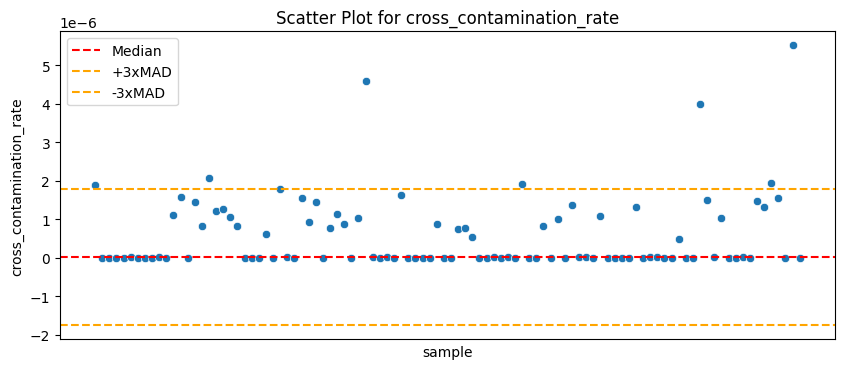

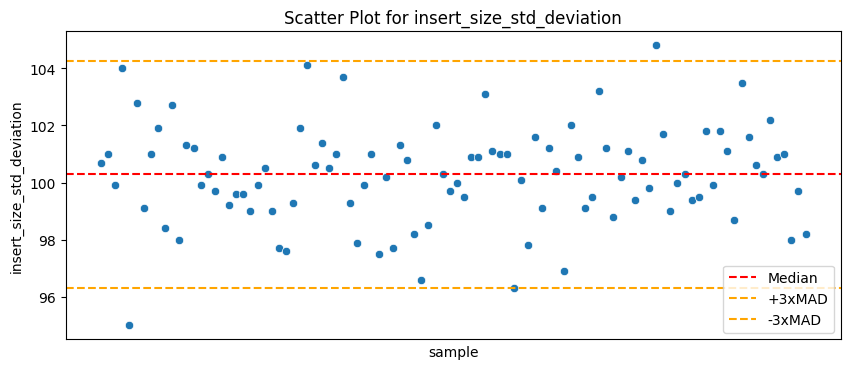

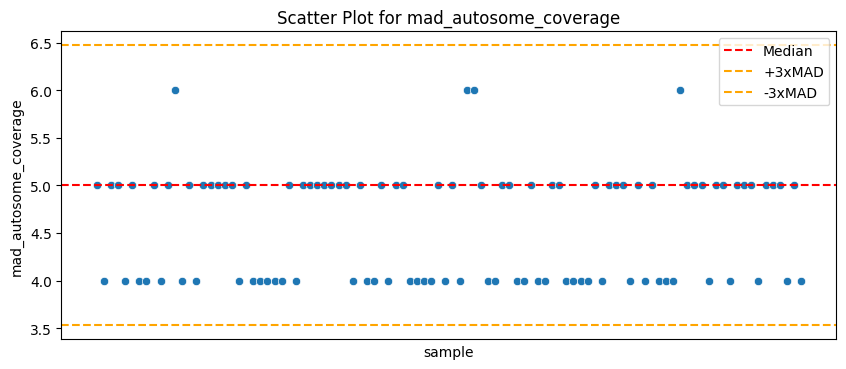

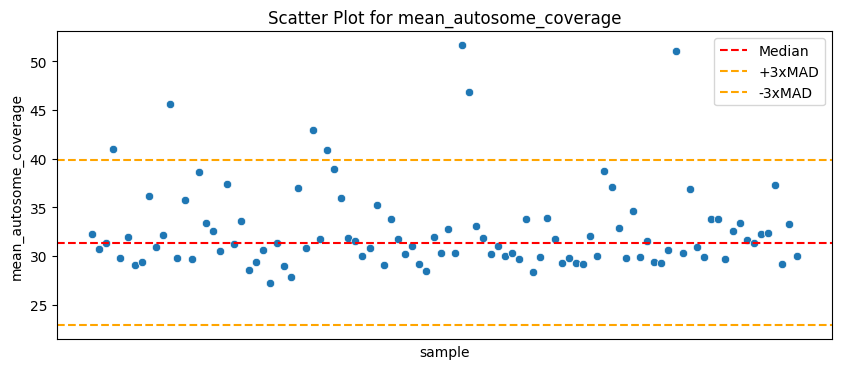

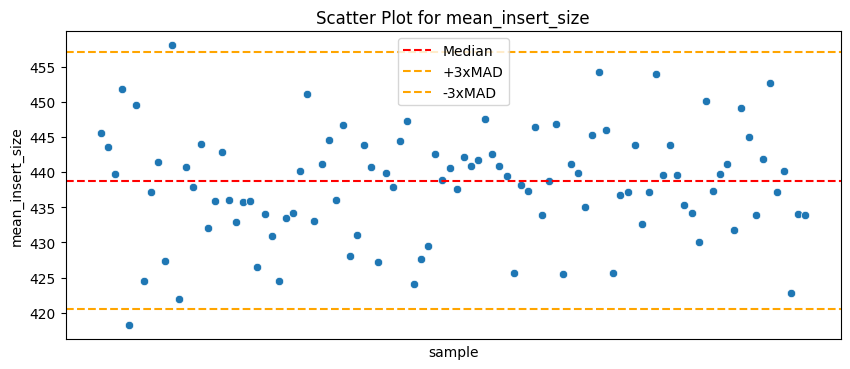

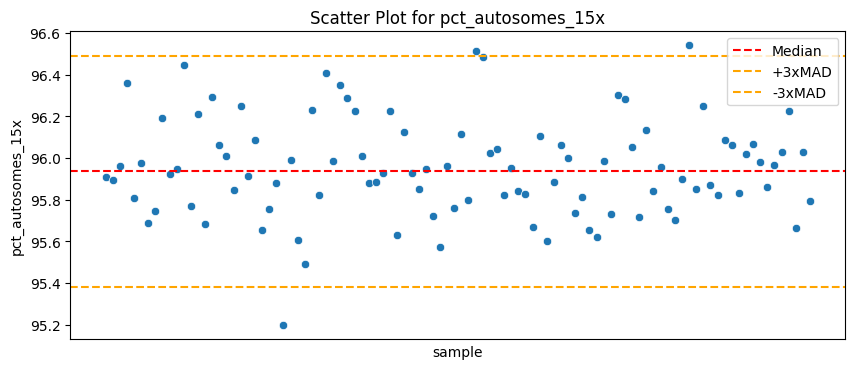

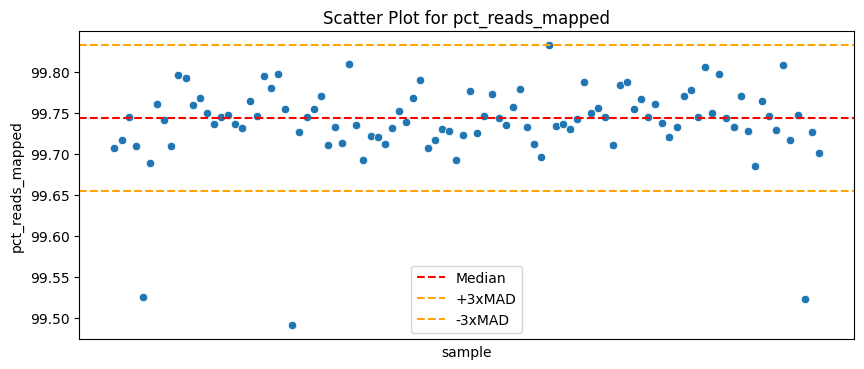

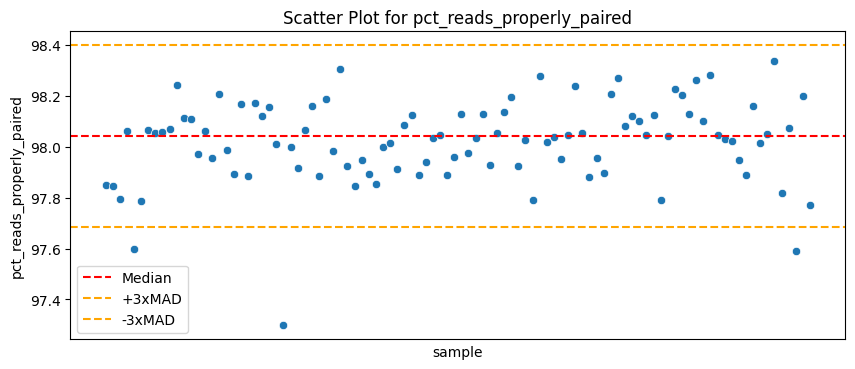

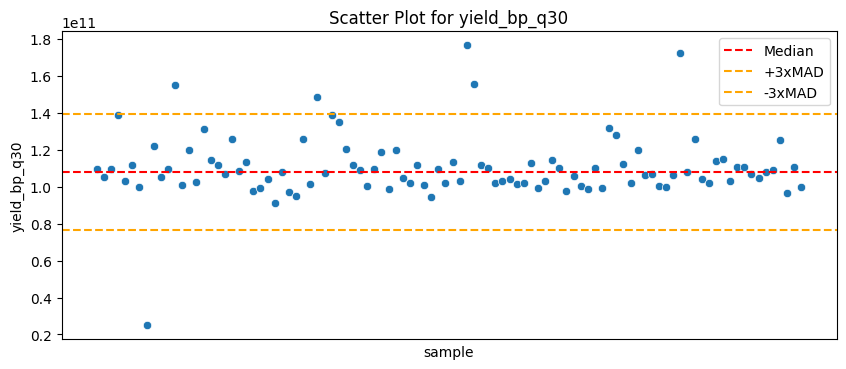

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Ignore FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# For each metric
for col in dft.columns[1:]:
    # Create a scatter plot
    plt.figure(figsize=(10, 4))
    sns.scatterplot(data=dft, x="index", y=col)
    
    # Calculate median and MAD
    median = dft[col].median()
    mad = np.mean(np.abs(dft[col] - median))
    
    # Add median and +/-3MAD lines
    plt.axhline(y=median, linestyle='--', color='red', label='Median')
    plt.axhline(y=median + 3 * mad, linestyle='--', color='orange', label='+3xMAD')
    plt.axhline(y=median - 3 * mad, linestyle='--', color='orange', label='-3xMAD')
    
    # Set plot title and labels
    plt.title(f"Scatter Plot for {col}")
    plt.xlabel("sample")
    plt.ylabel(col)
    plt.xticks([]) # Hide x-axis labels

    if col in ylims:
        plt.ylim(ylims[col][0], ylims[col][1])
    
    # Show legend
    plt.legend()
    
    # Show the plot
    plt.show()
